In [1]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import numpy as np
from tensorflow.keras import layers, models

In [8]:
HEIGHT = 500
WIDTH = 500

target_size = (HEIGHT, WIDTH)

with open('jiu_annotations.json', 'r') as file:
    annotations = json.load(file)

labels = {'standing': 1, 'takedown': 2, 'open_guard': 3, 'half_guard': 4, 'closed_guard': 5, '5050_guard': 6, 'side_control': 7, 'mount': 8, 'back': 9, 'turtle': 10}

num_labels = len(labels)

image_folder = 'D:\jiu_dataset\images'

num_keypoints = 17

images_normalized = []
annotations_formatted = []

try:

    for annotation in annotations:
        image_filename = annotation['image'] + '.jpg'
        image_path = os.path.join(image_folder, image_filename)
        
        print(image_filename)
        
        if image_filename == '0002026.jpg':
            break
        
        if not os.path.exists(image_path):
            break
        
        image_original_h, image_original_w = cv2.imread(image_path).shape[:2]

        img = load_img(image_path, target_size=target_size)  
        img_array = img_to_array(img)
        img_normalized = img_array / 255.0

        images_normalized.append(img_normalized)
        
        keypoints_array = []
        
        for i in range(num_keypoints):
            keypoint = 'pose1'
            
            if keypoint not in annotation:
                keypoint = 'pose2'
            
            x, y, c = annotation[keypoint][i]
            
            x_normalized = x / image_original_w
            y_normalized = y / image_original_h

            x_resized = int(x_normalized * target_size[1])
            y_resized = int(y_normalized * target_size[0])

            keypoints_array.append([x_resized, y_resized])

        label = labels.get(annotation['position'])
        
        annotations_formatted.append(keypoints_array)
        
    print(annotations_formatted)
        
    images_tensor = tf.convert_to_tensor(images_normalized, dtype=tf.float32)
    annotations_tensor = tf.convert_to_tensor(annotations_formatted, dtype=tf.float32)

    print(images_tensor.shape)
    print(annotations_tensor.shape)
    
except Exception as e:
    print("Error:", e)


0000001.jpg
0000002.jpg
0000003.jpg
0000004.jpg
0000005.jpg
0000006.jpg
0000007.jpg
0000008.jpg
0000009.jpg
0000010.jpg
0000011.jpg
0000012.jpg
0000013.jpg
0000014.jpg
0000015.jpg
0000016.jpg
0000017.jpg
0000018.jpg
0000019.jpg
0000020.jpg
0000021.jpg
0000022.jpg
0000023.jpg
0000024.jpg
0000025.jpg
0000026.jpg
0000027.jpg
0000028.jpg
0000029.jpg
0000030.jpg
0000031.jpg
0000032.jpg
0000033.jpg
0000034.jpg
0000035.jpg
0000036.jpg
0000037.jpg
0000038.jpg
0000039.jpg
0000040.jpg
0000041.jpg
0000042.jpg
0000043.jpg
0000044.jpg
0000045.jpg
0000046.jpg
0000047.jpg
0000048.jpg
0000049.jpg
0000060.jpg
0000061.jpg
0000062.jpg
0000063.jpg
0000064.jpg
0000065.jpg
0000066.jpg
0000067.jpg
0000068.jpg
0000069.jpg
0000070.jpg
0000071.jpg
0000072.jpg
0000073.jpg
0000074.jpg
0000075.jpg
0000076.jpg
0000077.jpg
0000078.jpg
0000079.jpg
0000080.jpg
0000081.jpg
0000082.jpg
0000083.jpg
0000084.jpg
0000085.jpg
0000086.jpg
0000087.jpg
0000088.jpg
0000089.jpg
0000090.jpg
0000091.jpg
0000092.jpg
0000093.jpg
0000

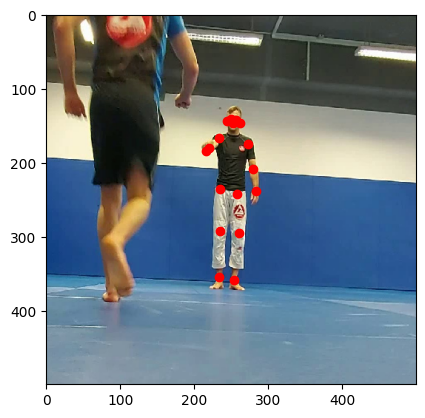

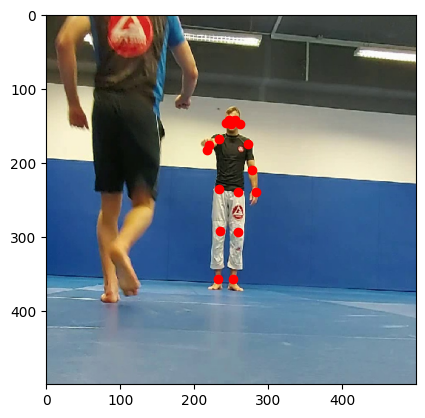

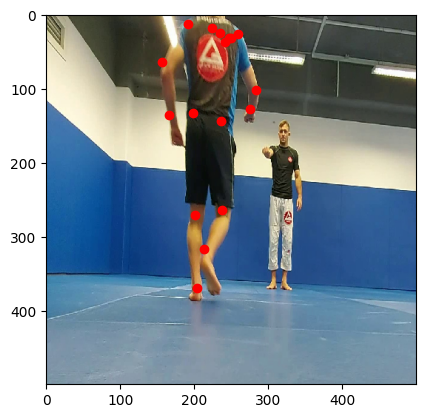

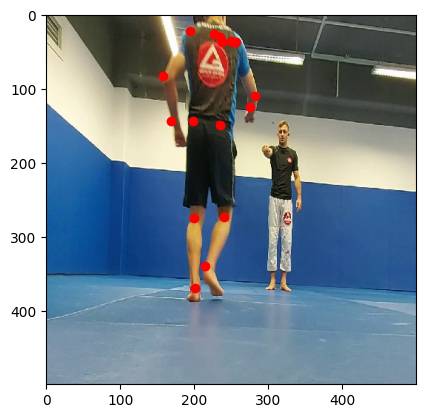

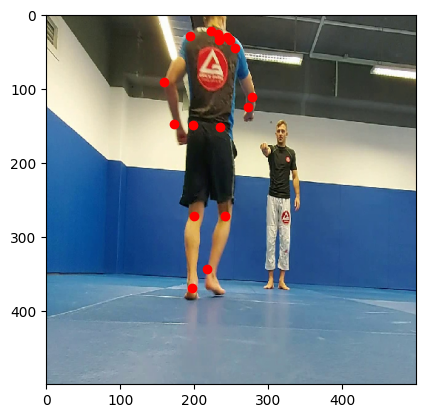

In [12]:
# show image with keypoints

import matplotlib.pyplot as plt

images_to_show = 5

for annotation, image in zip(annotations_formatted, images_normalized):
    plt.imshow(image)
    for i in range(num_keypoints):
        x, y = annotation[i]
        plt.scatter(x, y, c='r')
    plt.show()
    
    images_to_show -= 1
    
    if images_to_show == 0:
        break


In [13]:
def create_pose_detection_model(input_shape, num_keypoints):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output for fully connected layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_keypoints * 2, activation='relu'))
    model.add(layers.Reshape((num_keypoints, 2)))

    return model

input_shape = (HEIGHT, WIDTH, 3)

pose_detection_model = create_pose_detection_model(input_shape, num_keypoints)

pose_detection_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

pose_detection_model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)     

In [14]:
split_index = int(0.8 * len(images_tensor))

X_train, y_train = images_tensor[:split_index], annotations_tensor[:split_index]
X_val, y_val = images_tensor[split_index:], annotations_tensor[split_index:]

batch_size = 32

train_data_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=10000).batch(batch_size)
val_data_generator = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [15]:
num_epochs = 5

history = pose_detection_model.fit(train_data_generator, epochs=num_epochs, validation_data=val_data_generator)

Epoch 1/5


51/51 [==============================] - 265s 5s/step - loss: 15400.9238 - accuracy: 0.5430 - val_loss: 1704.6732 - val_accuracy: 0.6925
Epoch 2/5
51/51 [==============================] - 254s 5s/step - loss: 5080.5249 - accuracy: 0.6250 - val_loss: 2008.5308 - val_accuracy: 0.7320
Epoch 3/5
51/51 [==============================] - 257s 5s/step - loss: 3829.0557 - accuracy: 0.6613 - val_loss: 3732.7429 - val_accuracy: 0.7404
Epoch 4/5
51/51 [==============================] - 252s 5s/step - loss: 3241.2200 - accuracy: 0.6965 - val_loss: 1635.7803 - val_accuracy: 0.7233
Epoch 5/5
51/51 [==============================] - 249s 5s/step - loss: 2883.6870 - accuracy: 0.7227 - val_loss: 1954.4537 - val_accuracy: 0.7258


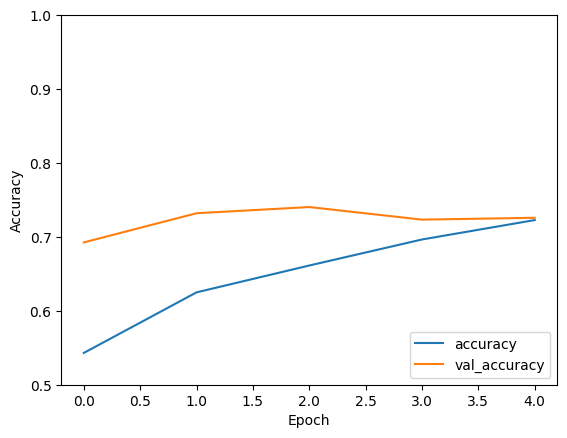

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

1/1 [==============================] - 1s 573ms/step
[[[198.47264 188.84679]
  [193.64238 180.53711]
  [182.91454 186.28076]
  [184.20946 185.84805]
  [189.3583  193.67471]
  [176.43024 208.88371]
  [198.4477  212.92291]
  [179.8866  224.00816]
  [203.27444 242.59023]
  [174.20435 225.67003]
  [209.11    241.0053 ]
  [179.28003 243.63112]
  [198.35007 253.5845 ]
  [178.01732 216.71968]
  [207.58524 224.3693 ]
  [186.50438 237.95404]
  [198.23438 237.9086 ]]]


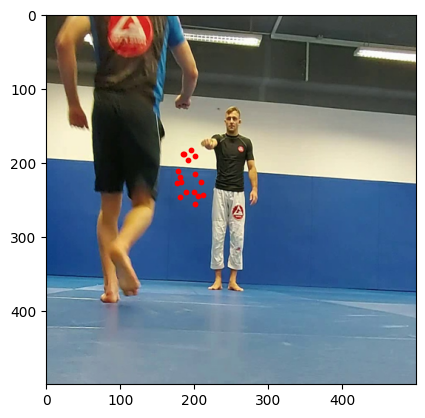

In [17]:
# test image

from PIL import Image

test_image = Image.open('images/0000002.jpg')

image = test_image.resize((WIDTH, HEIGHT))

plt.imshow(image)

image_array = np.array(image) / 255.0

image_array = np.expand_dims(image_array, axis=0)

keypoints = pose_detection_model.predict(image_array)

print(keypoints)

for i in range(num_keypoints):
    x, y = keypoints[0][i]
    plt.scatter(x + 2, y + 2, c='red', s=10)
    
plt.show()
    
